# Initial EDA for Points per Shot
Shooting data analysis for the 2017-18, 2018-19, and 2019-2020 NBA seasons

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nba_api.stats.endpoints as endpoints
from nba_api.stats.static import teams
from nba_api.stats.static import players

from sklearn.linear_model import LinearRegression

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
teams = teams.get_teams()
players = players.get_players()

In [6]:
team_ids_dict = { team['abbreviation']: team['id'] for team in teams }

## API codes and dataset organization
- **Season IDs**:
    - 1st Digit: 1 = Preseason, 2 = Regular season, 4 = Playoffs
    - Last 4 Digits: Start year of season
    
- **PlayerDashPtShots datasets from resultSets**:
    - 0: Overall Shooting
    - 1: General Shooting
    - 2: Shot Clock Shooting
    - 3: Dribble Shooting
    - 4: Closest Defender Shooting
    - 5: Closest Defender 10 feet+ Shooting (mid-range+)
    - 6: Touch Time Shooting

In [16]:
# Get player shooting from mid-range plus from 2017-18, 2018-19, and 2019-20 seasons
results = [
    endpoints.playerdashptshots.PlayerDashPtShots(team_id=0, player_id=0, season=season).get_data_frames()[5]
    for season in ['2017-18', '2018-19', '2019-20']
]

In [53]:
# Concat all data
df = pd.concat([ result for result in results ])

In [60]:
df.head()

,PLAYER_ID,PLAYER_NAME_LAST_FIRST,SORT_ORDER,GP,G,CLOSE_DEF_DIST_RANGE,FGA_FREQUENCY,FGM,FGA,FG_PCT,EFG_PCT,FG2A_FREQUENCY,FG2M,FG2A,FG2_PCT,FG3A_FREQUENCY,FG3M,FG3A,FG3_PCT
0,1627820,"Wallace, Tyrone",1,1222,1,0-2 Feet - Very Tight,0.0,0,1,0.000,0.000,0.0,0,1,0.000,0.0,0,0,NaN
1,2200,"Gasol, Pau",1,1222,5,0-2 Feet - Very Tight,0.0,2,5,0.400,0.400,0.0,2,5,0.400,0.0,0,0,NaN
2,201196,"Sessions, Ramon",1,1222,3,0-2 Feet - Very Tight,0.0,0,3,0.000,0.000,0.0,0,3,0.000,0.0,0,0,NaN
3,201596,"Chalmers, Mario",1,1222,7,0-2 Feet - Very Tight,0.0,3,9,0.333,0.333,0.0,3,7,0.429,0.0,0,2,0.0
4,1628502,"Hayes, Nigel",1,1222,1,0-2 Feet - Very Tight,0.0,0,1,0.000,0.000,0.0,0,1,0.000,0.0,0,0,NaN


## If and when is a midrange shot better than a 3?
### Relation between closest defender distance and points per shot (PPS)
There appears to be an almost linear relationship between defender distance and PPS.  Additionally, there does not appear to be a spike in PPS in the 6+ feet category.  This could indicate at some point greater than 6 feet the closest defender distance does not contribute heavily to PPS.

Here we can see that over the 3 seasons analyzed a midrange shot is generally worse with respect to points per shot when "all things are equal"; however, there are times when a midrange shot is a better shot than a 3 pointer.  Midrange shots that are open (closest defender within 4-6ft) are better than very tightly guarded (0-2ft) 3 pointers and wide open (6+ft) midrange shots are better than 3 point shots where the defenders are within 4ft of the shooter.

In [269]:
# Points per shot by closest defender
data = {'Defender Distance': [], 'Midrange PPS': [], 'Three PPS': []}
for i in df['CLOSE_DEF_DIST_RANGE'].unique():
    temp = df.loc[df['CLOSE_DEF_DIST_RANGE'] == i]
    midrange = round(temp['FG2M'].sum() / temp['FG2A'].sum() * 2, 4)
    three = round(temp['FG3M'].sum() / temp['FG3A'].sum() * 3, 4)
    data['Defender Distance'].append(i)
    data['Midrange PPS'].append(midrange)
    data['Three PPS'].append(three)

In [270]:
df_dd = pd.DataFrame(data).set_index('Defender Distance')
df_dd

,Midrange PPS,Three PPS
Defender Distance,,
0-2 Feet - Very Tight,0.7249,0.7963
2-4 Feet - Tight,0.7696,0.9051
4-6 Feet - Open,0.8436,1.0337
6+ Feet - Wide Open,0.9057,1.1518


In [266]:
dfp = pd.DataFrame(df_dd.unstack()).reset_index()

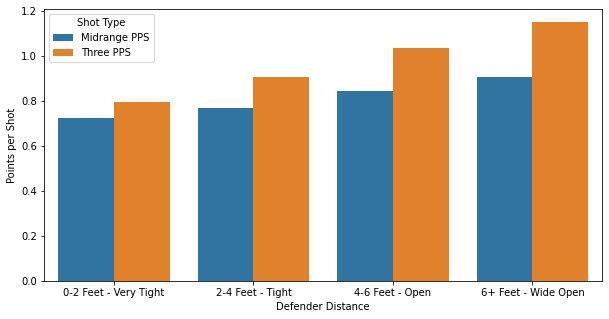

In [267]:
plt.figure(figsize=(10,5))
sns.barplot(data=dfp, x='Defender Distance', y=0, hue='level_0')
plt.ylabel('Points per Shot')
plt.legend(title='Shot Type')
plt.show()

## Who are the most prolific midrange shooters?

In [275]:
# Find the prolific (75th percentile) midrange shooters
df.groupby(['PLAYER_NAME_LAST_FIRST'])['FG2A'].sum().describe()

count     755.000000
mean      164.638411
std       249.012752
min         0.000000
25%         8.500000
50%        60.000000
75%       214.500000
max      1797.000000
Name: FG2A, dtype: float64

In [288]:
# Get all shooters with >214 midrange shots over the 3 seasons
a = df.groupby(['PLAYER_NAME_LAST_FIRST'])['FG2M', 'FG2A', 'FG3M', 'FG3A'].sum()
prolific = [ name for name in np.where(a['FG2A'] > 214, a.index, 0) if name != 0 ]

/Users/waynelam/nba/nba_player_pos/nba_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [289]:
len(prolific)

189

In [300]:
df2 = df.loc[df['PLAYER_NAME_LAST_FIRST'].isin(prolific)].groupby(['PLAYER_NAME_LAST_FIRST', 'CLOSE_DEF_DIST_RANGE'])['FG2M', 'FG2A', 'FG3M', 'FG3A'].sum().reset_index()

/Users/waynelam/nba/nba_player_pos/nba_venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [366]:
def shooter_data(name):
    temp = df2.loc[df2['PLAYER_NAME_LAST_FIRST'] == name].copy()
    temp['FG2PPS'] = temp['FG2M'] / temp['FG2A'] * 2
    temp['FG3PPS'] = temp['FG3M'] / temp['FG3A'] * 3

    temp['FG2PPS'] = np.where(temp['FG2PPS'].isna(), 0, temp['FG2PPS'])
    temp['FG3PPS'] = np.where(temp['FG3PPS'].isna(), 0, temp['FG3PPS'])
    temp.drop(columns=['FG2M', 'FG2A', 'FG3M', 'FG3A', 'PLAYER_NAME_LAST_FIRST'], inplace=True)
    temp.set_index('CLOSE_DEF_DIST_RANGE', inplace=True)
    temp = temp.stack().reset_index()
    temp.columns = ['Closest Defender (feet)', 'Shot Type', 'PPS']
    temp['Shot Type'] = np.select(
        [temp['Shot Type'] == 'FG2PPS', temp['Shot Type'] == 'FG3PPS'],
        ['Midrange', 'Three']
    )
    
    plt.figure(figsize=(10,5))
    sns.barplot(data=temp, x='Closest Defender (feet)', y='PPS', hue='Shot Type')
    plt.xlabel('Closest Defender (feet)')
    plt.ylabel('Points per Shot')
    plt.title(f'{name}')
    
    return plt.show()

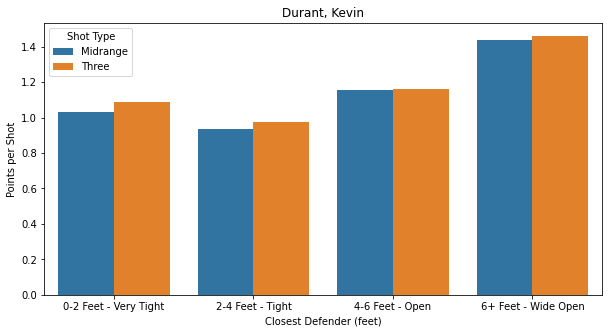

In [369]:
name = 'Durant, Kevin'
shooter_data(name)

## Additional Estimations - Linear Regression

In [217]:
# Map bins to defender distances (>6ft -> 7 for consistency) and create linear regression
reg_mid = LinearRegression()
reg_three = LinearRegression()
X_mid = np.array([1, 3, 5, 7]).reshape((4,1))
X_three = np.array([1, 3, 5, 7]).reshape((4,1))
y_mid = np.array(df_plot['Midrange PPS']).reshape((4,1))
y_three = np.array(df_plot['Three PPS']).reshape((4,1))
reg_mid.fit(X_mid, y_mid)
reg_three.fit(X_three, y_three)

# R-squared
print('Midrange Regression R-Squared:', round(reg_mid.score(X_mid, y_mid), 4))
print('Three Regression R-Squared:', round(reg_three.score(X_three, y_three), 4))

Midrange Regression R-Squared: 0.9916
Three Regression R-Squared: 0.9991


In [218]:
mid_zero = reg_mid.predict([[0]])
mid_six = reg_mid.predict([[6]])
three_zero = reg_three.predict([[0]])
three_six = reg_three.predict([[6]])

In [219]:
mid_slope = float(np.round((mid_six - mid_zero) / 6, 4))
three_slope = float(np.round((three_six - three_zero) / 6, 4))

In [220]:
# Estimate PPS increase per foot
s = 'PPS increase with each foot of closest defender distance:'
print(s)
print('-' * len(s))
print('Midrange:', mid_slope)
print('Three:', three_slope)

PPS increase with each foot of closest defender distance:
---------------------------------------------------------
Midrange: 0.0308
Three: 0.0598


In [221]:
# Create x, y coordinates for lines
x = np.linspace(0, 7, 100)
y1 = mid_slope*x + float(mid_zero)
y2 = three_slope*x + float(three_zero)

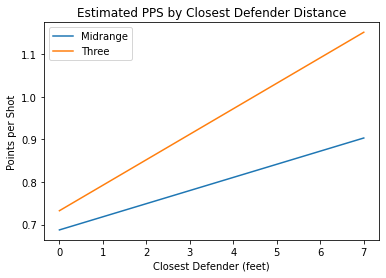

In [222]:
# Plot estimators
plt.plot(x, y1, label='Midrange')
plt.plot(x, y2, label='Three')
plt.title('Estimated PPS by Closest Defender Distance')
plt.xlabel('Closest Defender (feet)')
plt.ylabel('Points per Shot')
plt.legend()
plt.show()

In [223]:
def line_func(x, slope=three_slope, intercept=three_zero):
    return round(float(slope)*x + float(intercept), 4)

In [224]:
def return_x(y, slope=three_slope, intercept=three_zero):
    return round((y - float(intercept)) / slope, 4)

In [237]:
# Maximum PPS for midrange
mid_max = line_func(7, mid_slope, mid_zero)

# Equivalent closest defender distance for 3s
equiv = return_x(mid_max)
feet = round(equiv // 1)
inches = round(equiv * 12 % 12)
print('Closest Defender:', f"{feet}'" + f'{inches}"')

Closest Defender: 2'10"
